# Biggest Vendors Analysis

In [1]:
from bs4 import BeautifulSoup as bs
import os
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import plotly.express as px
import descartes
import re
from datetime import datetime
import calmap
import geopandas
import geoplot
import shapefile as shp
import matplotlib.dates as mdates
import datetime as dt

from sklearn.linear_model import LinearRegression, LogisticRegression
from VendorsParsingTools import *
from ForumParsingTools import *
from ProductListingParsingTools import *

from pyspark import *
from pyspark.sql import *
from pyspark.sql.functions import *
import re
from pyspark.sql.types import ArrayType
from pyspark.sql.types import StringType

### We want names

First, work on the vendors.  
We want to keep only the "best" vendors, ie those who have more thant 5000 deals.

In [2]:
vendorsDF = pd.read_csv('cleanVendorsDF.csv', index_col = 0)
vendorsDF

,name,rating,lastSeen,publicKey,#products,#Deals,parsingDate
0,littlegoblin,4.92,4,NaN,14.0,150~200,2014-09-20
1,Rebel_Alliance,4.99,1,NaN,7.0,300~500,2014-09-20
2,ThePartyDepot,5.00,16,NaN,3.0,70~100,2014-09-20
3,cossacks,4.99,5,NaN,7.0,300~500,2014-09-20
4,checkpoint,4.84,24,NaN,31.0,55~70,2014-09-20
...,...,...,...,...,...,...,...
121153,BabyBando,5.00,3,NaN,6.0,10~15,2014-10-14
121154,daydreamer33,4.94,24,NaN,6.0,200~300,2014-10-14
121155,Leckermann,5.00,4176,NaN,8.0,3~5,2014-10-14
121156,EasyRiders,NaN,NaN,NaN,5.0,0,2014-10-14


In [3]:
nbDealsValues = vendorsDF['#Deals'].unique()
nbDealsValues

array(['150~200', '300~500', '70~100', '55~70', '500~1000', '0', '1000+',
       '100~150', '40~55', '200~300', '6~10', '1~2', '25~40', ' 1~2',
       '15~25', '10~15', '3~5', nan, ' 3~5', '1000~1500', '4000~5000',
       '1000~2000', '3000~4000', '2000~3000', '5000+', ' 10~15', ' 6~10',
       '3000~404', ' 15~25'], dtype=object)

In [4]:
bigNames = vendorsDF[vendorsDF['#Deals'] == '5000+']['name'].unique()
bigNames

array(['medibuds', 'MrCronk', 'captainkirk', 'Saint_Symbiosis',
       'DrawkwarD', 'Drugs4you', 'HouseofSpirit', 'DutchMagic'],
      dtype=object)

In [5]:
bigNamesList = bigNames.astype(str).tolist()
bigNamesList

['medibuds',
 'MrCronk',
 'captainkirk',
 'Saint_Symbiosis',
 'DrawkwarD',
 'Drugs4you',
 'HouseofSpirit',
 'DutchMagic']

Now, we have the top 8 vendors.

### Spark time
No we are going to recover the market DATA

In [6]:
def init_spark(app_name, master_config):
    """
    :params app_name: Name of the app
    :params master_config: eg. local[4]
    :returns SparkContext, SQLContext, SparkSession:
    """
    conf = (SparkConf().setAppName(app_name).setMaster(master_config))

    sc = SparkContext(conf=conf)
    sc.setLogLevel("ERROR")
    sql_ctx = SQLContext(sc)
    spark = SparkSession(sc)

    return (sc, sql_ctx, spark)

In [7]:
sc, sql_ctx, spark = init_spark("App_name", "local[4]")

In [8]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
df = spark.read.option("header", "true").csv("../data/cat_csv/*.csv")
df.count()

2805212

In [9]:
def processCountries(country):
    # Remove html tags
    cleanr = re.compile('<.*?>')
    cleanText = str(re.sub(cleanr, '', str(country)))
    
    # Remove spaces
    cleanText = cleanText.strip(' ')
    
    # Remove ""
    cleanText = cleanText.strip('"')
    
    # Split for each country
    cleanText = re.split("&|,|/", cleanText)
    
    # Top Names reformat
    cleanText = [re.sub(r'^(eu|europeanunion|euonly|europeuniononly|onlytoeurope|europeancountries|westerneurope|ukandeuonly|franceandeu)$', r'europe', w) for w in cleanText]
    cleanText = [re.sub(r'^(everywhere|world|international|anywhere|worlwide|worldwideonrequest|ww|wordwide|global|worldwideinternational|wideworld|all|worldwidepriortracking|wordlwide|worldwideprior|worldwideprior|internationalworldwide|universe|everywhereworldwideanydestination|wolrdwide|wwshipping|freeworldwide|universal|woldwide|worldwideincludingaustralia|worldwidepriorthefastest|internationally)$', r'worldwide', w) for w in cleanText]
    cleanText = [re.sub(r'^(usaonly|unitedstates|us|unitedstatesofamerica|usonly|unitedstatesonly)$', r'usa', w) for w in cleanText]
    cleanText = [re.sub(r'^(unitedkingdom|ukonly)$', r'uk', w) for w in cleanText]
    return cleanText

udf_func_C = udf(processCountries, ArrayType(StringType()))

def processCatHashs(cat_hash):
    # Remove html end of files
    cleanr = re.compile('.\d*.html')
    cleanText = str(re.sub(cleanr, '', str(cat_hash)))
    return cleanText

udf_func_H = udf(processCatHashs, StringType())

# Remove rows without a valid date, error during parsing, file not complete
df = df.filter(df["date"].rlike("\d\d\d\d-\d\d-\d\d"))

# Remove rows without a price or not decimal, 642 in total, mainly due to error during parsing.
df = df.filter("CAST(price AS DECIMAL) is not null")

# Remove the rows where name is null, all the columns are usually null in this case, (6 rows)
df = df.filter("name is not null")

# Lowercase and process the countries
df=df.withColumn("to", lower(col("to")))
df=df.withColumn("to", udf_func_C(col("to")))

# Lowercase and process the countries
df=df.withColumn("from", lower(col("from")))
df=df.withColumn("from", udf_func_C(col("from")))

# Process the hashs
df=df.withColumn("cat_hash", udf_func_H(col("cat_hash")))

In [10]:
type(df)

pyspark.sql.dataframe.DataFrame

In [11]:
df

DataFrame[_c0: string, name: string, price: string, from: array<string>, to: array<string>, vendor: string, cat_hash: string, cat: string, date: string]

In [12]:
df = df.drop('from').drop('to')

In [13]:
df.show()

+---+--------------------+----------+-------------+----------+--------------------+----------+
|_c0|                name|     price|       vendor|  cat_hash|                 cat|      date|
+---+--------------------+----------+-------------+----------+--------------------+----------+
|  0|Jack Herer from S...|0.73044494|   MrSunshine|rdffTvGkMC|Drugs/Cannabis/Seeds|2015-06-20|
|  1|WHITE WIDOW FEMIN...|3.31830703|  klosterbier|rdffTvGkMC|Drugs/Cannabis/Seeds|2015-06-20|
|  2|WHITE WIDOW FEMIN...|0.85149010|  klosterbier|rdffTvGkMC|Drugs/Cannabis/Seeds|2015-06-20|
|  3|SMART START - See...|0.07091576|  klosterbier|rdffTvGkMC|Drugs/Cannabis/Seeds|2015-06-20|
|  4|Marijuana Grow Ba...|0.00542616|      Optumis|rdffTvGkMC|Drugs/Cannabis/Seeds|2015-06-20|
|  5|SMART START - See...|0.07091576|  klosterbier|rdffTvGkMC|Drugs/Cannabis/Seeds|2015-06-20|
|  6| Custom for southpsy|0.18762000|  klosterbier|rdffTvGkMC|Drugs/Cannabis/Seeds|2015-06-20|
|  7|Jack Herer from S...|0.31304783|   MrSunshine

In [14]:
bvDF = df.where(col('vendor').isin(*bigNamesList))
bvDF

DataFrame[_c0: string, name: string, price: string, vendor: string, cat_hash: string, cat: string, date: string]

In [15]:
bvDF.show()

+---+--------------------+----------+-----------+----------+-----------------+----------+
|_c0|                name|     price|     vendor|  cat_hash|              cat|      date|
+---+--------------------+----------+-----------+----------+-----------------+----------+
|367|Cannabis Alchemy ...|0.00400000|captainkirk|JAmvyj8iBs|Info/eBooks/Drugs|2015-06-20|
|373|Marijuana Grow Ba...|0.00400000|captainkirk|JAmvyj8iBs|Info/eBooks/Drugs|2015-06-20|
|393|Fixing Drugs: The...|0.00400000|captainkirk|JAmvyj8iBs|Info/eBooks/Drugs|2015-06-20|
|395|Psilocybin Produc...|0.00400000|captainkirk|JAmvyj8iBs|Info/eBooks/Drugs|2015-06-20|
|396|One Pot Shake and...|0.00400000|captainkirk|JAmvyj8iBs|Info/eBooks/Drugs|2015-06-20|
|399|Journeys Into The...|0.00400000|captainkirk|JAmvyj8iBs|Info/eBooks/Drugs|2015-06-20|
|402|Sacred Vine of Sp...|0.00400000|captainkirk|JAmvyj8iBs|Info/eBooks/Drugs|2015-06-20|
|405|Drugs, The Straig...|0.00400000|captainkirk|JAmvyj8iBs|Info/eBooks/Drugs|2015-06-20|
|408|Stash

In [16]:
bigVendorsDF = bvDF.toPandas().drop(columns = '_c0')
bigVendorsDF

,name,price,vendor,cat_hash,cat,date
0,Cannabis Alchemy - D. Gold,0.00400000,captainkirk,JAmvyj8iBs,Info/eBooks/Drugs,2015-06-20
1,Marijuana Grow Basics: The Easy Guide for Cann...,0.00400000,captainkirk,JAmvyj8iBs,Info/eBooks/Drugs,2015-06-20
2,Fixing Drugs: The Politics of Drug Prohibition,0.00400000,captainkirk,JAmvyj8iBs,Info/eBooks/Drugs,2015-06-20
3,Psilocybin Producer's Guide,0.00400000,captainkirk,JAmvyj8iBs,Info/eBooks/Drugs,2015-06-20
4,One Pot Shake and Bake Meth Cooking,0.00400000,captainkirk,JAmvyj8iBs,Info/eBooks/Drugs,2015-06-20
...,...,...,...,...,...,...
120558,Bumfights 4: Return Of Ruckus (2006),0.00258411,captainkirk,evljk7AG11,Other,2014-10-16
120559,Natural Born Killers (1994) 720p,0.00258411,captainkirk,evljk7AG11,Other,2014-10-16
120560,The Rise and Rise of Bitcoin (2014),0.00258411,captainkirk,evljk7AG11,Other,2014-10-16
120561,Hackers [1995] DvDrip,0.00258411,captainkirk,evljk7AG11,Other,2014-10-16


In [17]:
plp = bigVendorsDF.set_index('vendor')
plp

,name,price,cat_hash,cat,date
vendor,,,,,
captainkirk,Cannabis Alchemy - D. Gold,0.00400000,JAmvyj8iBs,Info/eBooks/Drugs,2015-06-20
captainkirk,Marijuana Grow Basics: The Easy Guide for Cann...,0.00400000,JAmvyj8iBs,Info/eBooks/Drugs,2015-06-20
captainkirk,Fixing Drugs: The Politics of Drug Prohibition,0.00400000,JAmvyj8iBs,Info/eBooks/Drugs,2015-06-20
captainkirk,Psilocybin Producer's Guide,0.00400000,JAmvyj8iBs,Info/eBooks/Drugs,2015-06-20
captainkirk,One Pot Shake and Bake Meth Cooking,0.00400000,JAmvyj8iBs,Info/eBooks/Drugs,2015-06-20
...,...,...,...,...,...
captainkirk,Bumfights 4: Return Of Ruckus (2006),0.00258411,evljk7AG11,Other,2014-10-16
captainkirk,Natural Born Killers (1994) 720p,0.00258411,evljk7AG11,Other,2014-10-16
captainkirk,The Rise and Rise of Bitcoin (2014),0.00258411,evljk7AG11,Other,2014-10-16


### Convert BTC to \$  
Since the bitcoin evolve a lot over time, we want ton convert it to more significant value, ie $

In [18]:
btcPriceDF= pd.read_csv("../data/bitcoin_csv.csv",usecols=['date', 'price(USD)'])
btcPriceDF = btcPriceDF.dropna()
btcPriceDF = btcPriceDF.rename(columns ={'price(USD)':'price'})
btcPriceDF

,date,price
1570,2013-04-28,135.30
1571,2013-04-29,134.44
1572,2013-04-30,144.00
1573,2013-05-01,139.00
1574,2013-05-02,116.38
...,...,...
3600,2018-11-18,5559.74
3601,2018-11-19,5620.78
3602,2018-11-20,4863.93
3603,2018-11-21,4465.54


In [19]:
def convertDates(s):
    return dt.datetime.strptime(s, '%b %d, %Y')

def convertDatesAVGPrice(s):
    return dt.datetime.strptime(s, '%Y-%m-%d')

## Data Analysis
- Make some plots for everything
- check price evolution (B/A onymous)
- check average nb of products per vendors (B/A onymous)

In [20]:
bigVendorsDF

,name,price,vendor,cat_hash,cat,date
0,Cannabis Alchemy - D. Gold,0.00400000,captainkirk,JAmvyj8iBs,Info/eBooks/Drugs,2015-06-20
1,Marijuana Grow Basics: The Easy Guide for Cann...,0.00400000,captainkirk,JAmvyj8iBs,Info/eBooks/Drugs,2015-06-20
2,Fixing Drugs: The Politics of Drug Prohibition,0.00400000,captainkirk,JAmvyj8iBs,Info/eBooks/Drugs,2015-06-20
3,Psilocybin Producer's Guide,0.00400000,captainkirk,JAmvyj8iBs,Info/eBooks/Drugs,2015-06-20
4,One Pot Shake and Bake Meth Cooking,0.00400000,captainkirk,JAmvyj8iBs,Info/eBooks/Drugs,2015-06-20
...,...,...,...,...,...,...
120558,Bumfights 4: Return Of Ruckus (2006),0.00258411,captainkirk,evljk7AG11,Other,2014-10-16
120559,Natural Born Killers (1994) 720p,0.00258411,captainkirk,evljk7AG11,Other,2014-10-16
120560,The Rise and Rise of Bitcoin (2014),0.00258411,captainkirk,evljk7AG11,Other,2014-10-16
120561,Hackers [1995] DvDrip,0.00258411,captainkirk,evljk7AG11,Other,2014-10-16


In [105]:
##Drop useless columns and sort by date
zi = bigVendorsDF.drop(columns = ['name', 'cat_hash', 'cat'])
zi['price'] = zi['price'].astype('float')
zi = zi.sort_values('date')
zi

,price,vendor,date
120130,0.037291,medibuds,2014-01-01
120058,0.600801,HouseofSpirit,2014-01-01
120060,0.767690,HouseofSpirit,2014-01-01
120061,95.000000,HouseofSpirit,2014-01-01
120062,0.200267,HouseofSpirit,2014-01-01
...,...,...,...
4511,0.003653,captainkirk,2015-07-07
4512,0.003653,captainkirk,2015-07-07
4513,0.003653,captainkirk,2015-07-07
4502,0.003653,captainkirk,2015-07-07


In [110]:
#index by date with mean price per vendor
tp = zi.groupby(['date', 'vendor'])['price'].mean()
tp = tp.to_frame().reset_index('vendor')
tp

,vendor,price
date,,
2014-01-01,HouseofSpirit,3.180622
2014-01-01,MrCronk,0.179162
2014-01-01,medibuds,0.121514
2014-01-09,HouseofSpirit,3.135773
2014-01-09,MrCronk,0.193043
...,...,...
2015-07-07,Drugs4you,0.759231
2015-07-07,MrCronk,6.362813
2015-07-07,Saint_Symbiosis,1.220897


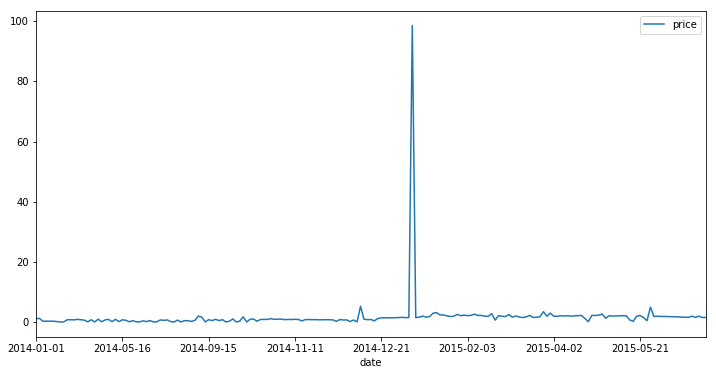

In [118]:
## Compute mean price per date
mn_price = tp['price'].mean(level = 'date').to_frame()
mn_price.plot(figsize=(12,6))

In [122]:
#Compute value of the pic
maxVal = mn_price.idxmax()
maxVal

price    2015-01-06
dtype: object